## Sentiment classification of 100 forum posts using GPT models via API
This notebook evaluates 100 extracted forum posts (forum_posts_100_test.csv) using two different GPT models by OpenAI via their API. The performance of these GPT models was compared against each other, the three previously evaluated open-source models, and human-labeled classifications.

The goal was to determine if one of the GPT models would be sufficiently good so that it could be used to classify a larger set of formum posts which then in turn could be used as training data to fine-tune one of the more lightweight, open-source models for the sentiment analysis.

In [ ]:
from google.colab import drive
drive.mount ("/content/drive")

Mounted at /content/drive


In [ ]:
!pip install openai
import openai
from openai import OpenAI
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import yaml
with open ("/content/drive/MyDrive/github_projects/fine_tuning_ai_for_sentiments/config/config.yaml", "r") as f:
  config = yaml.safe_load(f)

# load the key from the yaml file
with open("/content/drive/MyDrive/github_projects/chatgpt_api_credentials.yaml", "r") as file:
  chatgpt_api = yaml.safe_load(file)

# Ensuring that the OpenAI API key is loaded correctly
display(chatgpt_api.keys())

dict_keys(['openAI_key'])

In [ ]:
# os.environ is a dictionary with environment variables
# store the OpenAI API key on such environment variable for secure access
import os
os.environ["OPENAI_API_KEY"] = chatgpt_api["openAI_key"]
# setting the OpenAI key from the environment variable
openai.api_key = os.getenv("OPENAI_API_KEY")

In [ ]:
# loading the previously saved files with the 100 forum posts

# # either the csv file containing the pure formum posts
# df_forum_posts_100_test = pd.read_csv(config["project_path"]+config["data_processed_dir"]+"forum_posts_100_test.csv")
# display(df_forum_posts_100_test)

# or the csv file which already contains the classifications performed by human and the three evaluated open-source models
df_forum_posts_100_test =  pd.read_csv(config["project_path"]+config["data_processed_dir"]+"forum_posts_100_test_classification_by_human_and_3_open_source_models.csv")
df_forum_posts_100_test

,ID,text,datetime,company,sentiment_oliverguhr,sentiment_bardsai,sentiment_lxyuan,classification_by_human
0,741247,"Lass das nicht Deine Perle lesen, sonst musst...",2010-03-31 10:16:04,Infineon_Technologies,negative,neutral,negative,negative
1,1392918,"Wirecard ist zu unrecht abgestraft, ich finde...",2019-05-04 14:25:17,Wirecard,negative,neutral,negative,positive
2,917829,"jo und den chart anschauen, nie am höchepunkt...",2022-10-24 20:48:08,LPKF_Laser_und_Electronics,negative,neutral,positive,negative
3,914213,godmode-trader.de,2013-02-22 16:11:14,LPKF_Laser_und_Electronics,positive,neutral,positive,neutral
4,36252,"Das gilt nur für die Adler Group SA, oder auch...",2022-12-09 09:51:20,ADLER_Real_Estate,neutral,neutral,negative,neutral
...,...,...,...,...,...,...,...,...
95,1401875,Bin ja auch sehr optimistisch gestimmt. ...,2019-03-16 19:43:12,Wirecard,positive,positive,negative,positive
96,1243426,heute sieht es so aus als würde die Unterstütz...,2018-09-04 13:44:38,Volkswagen,neutral,neutral,negative,negative
97,1114627,"Wieder keine Vola, obwohl der Gesamtmarkt neu...",2020-08-26 09:17:15,Secunet_Security_Networks,negative,neutral,negative,neutral
98,1060385,du wirst es nie lernen ! substanz sieht an...,2006-10-17 17:37:43,PVA_TePla,negative,neutral,negative,negative


### Preparing and testing the function to conduct the GPT via the API

In [ ]:
# creating a function to conduct the API calls on the GPT models from OpenAI
# detailed doc see here: https://platform.openai.com/docs/api-reference/chat/create

def get_sentiment_classifications(text, model):
    """
    Classifies the sentiment of a given text (e.g. forum post in the presented case)
    using a selected GPT model from OpenAI via their API.

    The function sends a text to the selected GPT model with a prompt to classify
    the sentiment either as negative, neutral or positive. It expects the model to
    return a single word indicating this sentiment.

    Parameters:
    - text (str): The text of the forum post to be classified.
    - model (str): The name of the GPT model to used for doing the classification.
                  Overview of the available models: https://platform.openai.com/docs/models/gpt-4-and-gpt-4-turb

    Returns:
    - str: The detected sentiment of the review as determined by the model
            ("negative", "neutral", "positive"). If an exception occurs, instead
            of a sentiment the error message is returned
    """

    try:
        messages = [
            {"role": "system",
             "content": """You are an AI language model trained to analyze
                            and detect the sentiment of forum posts."""},
            {"role": "user",
             "content": f"""Analyze the following forum post and determine
                            if the sentiment is: negative, neutral or positive.
                            Return only a single word, either negative, neutral
                             or positive: {text}"""}
        ]
        # client referst to the OpenAI() client that sends the request
        client = OpenAI()

        # "completion" refers to the text that the model generates in response to an input prompt
        completion = client.chat.completions.create(
            model=model,
            messages=messages,
            max_tokens=1,
            n=1,                #the number of responses the model will generate for the given input
            temperature=0
        )
        # extracting the sentiment classification from the received answer
        sentiment = completion.choices[0].message.content.lower()
        return sentiment

    #captures all the errors and returns the error statements for analysis
    except Exception as e:
        return f"error: {e}"

In [ ]:
# testing the function to verify that the API calls and sentiment classification are working correctly
test_texts = ["That's a bad thing", "That's a neutral thing", "Thats a great thing"]
for text in test_texts:
  print(get_sentiment_classifications(text, "gpt-3.5-turbo"))

negative
neutral
positive


In [ ]:
# checking which two GPT models have been selected in the config files for sentiment classifications
print(config["test_data_eval_model1"])
print(config["test_data_eval_model2"])

gpt-3.5-turbo
gpt-4-turbo-preview


In [ ]:
# validating the function on a DataFrame to ensure correct functionality
df_test = df_forum_posts_100_test.head(3).copy()
df_test["sentiment_"+config["test_data_eval_model1"]] = df_test["text"].apply(lambda text: get_sentiment_classifications(text, config["test_data_eval_model1"]))
df_test["sentiment_"+config["test_data_eval_model2"]] = df_test["text"].apply(lambda text: get_sentiment_classifications(text, config["test_data_eval_model2"]))
df_test

,ID,text,datetime,company,sentiment_oliverguhr,sentiment_bardsai,sentiment_lxyuan,classification_by_human,sentiment_gpt-3.5-turbo,sentiment_gpt-4-turbo-preview
0,741247,"Lass das nicht Deine Perle lesen, sonst musst...",2010-03-31 10:16:04,Infineon_Technologies,negative,neutral,negative,negative,negative,negative
1,1392918,"Wirecard ist zu unrecht abgestraft, ich finde...",2019-05-04 14:25:17,Wirecard,negative,neutral,negative,positive,positive,positive
2,917829,"jo und den chart anschauen, nie am höchepunkt...",2022-10-24 20:48:08,LPKF_Laser_und_Electronics,negative,neutral,positive,negative,negative,neutral


### Sentiment classification on the 100 forum posts using two GPT models

In [ ]:
df_forum_posts_100_test

,ID,text,datetime,company,sentiment_oliverguhr,sentiment_bardsai,sentiment_lxyuan,classification_by_human
0,741247,"Lass das nicht Deine Perle lesen, sonst musst...",2010-03-31 10:16:04,Infineon_Technologies,negative,neutral,negative,negative
1,1392918,"Wirecard ist zu unrecht abgestraft, ich finde...",2019-05-04 14:25:17,Wirecard,negative,neutral,negative,positive
2,917829,"jo und den chart anschauen, nie am höchepunkt...",2022-10-24 20:48:08,LPKF_Laser_und_Electronics,negative,neutral,positive,negative
3,914213,godmode-trader.de,2013-02-22 16:11:14,LPKF_Laser_und_Electronics,positive,neutral,positive,neutral
4,36252,"Das gilt nur für die Adler Group SA, oder auch...",2022-12-09 09:51:20,ADLER_Real_Estate,neutral,neutral,negative,neutral
...,...,...,...,...,...,...,...,...
95,1401875,Bin ja auch sehr optimistisch gestimmt. ...,2019-03-16 19:43:12,Wirecard,positive,positive,negative,positive
96,1243426,heute sieht es so aus als würde die Unterstütz...,2018-09-04 13:44:38,Volkswagen,neutral,neutral,negative,negative
97,1114627,"Wieder keine Vola, obwohl der Gesamtmarkt neu...",2020-08-26 09:17:15,Secunet_Security_Networks,negative,neutral,negative,neutral
98,1060385,du wirst es nie lernen ! substanz sieht an...,2006-10-17 17:37:43,PVA_TePla,negative,neutral,negative,negative


In [ ]:
# #CAREFUL This Cell is EXPENSIVE because of the GTP API use!!!
# df_forum_posts_100_test_gpt_classified = df_forum_posts_100_test.copy()
# df_forum_posts_100_test_gpt_classified["sentiment_"+config["test_data_eval_model1"]] = df_forum_posts_100_test_gpt_classified["text"].apply(lambda t: get_sentiment_classifications(t, config["test_data_eval_model1"]).lower())
# df_forum_posts_100_test_gpt_classified["sentiment_"+config["test_data_eval_model2"]] = df_forum_posts_100_test_gpt_classified["text"].apply(lambda t: get_sentiment_classifications(t, config["test_data_eval_model2"]).lower())
# df_forum_posts_100_test_gpt_classified.to_csv(config["project_path"]+config["data_processed_dir"]+"forum_posts_100_test_classification_by_human_and_3_open_source_models_and_2_GPT_models.csv", index = False, encoding = "utf-8")
# df_forum_posts_100_test_gpt_classified

##Evaluating the performance of the two GPT models

In [ ]:
# loading the previously saved files with the forum posts with the classifications performed by human, the three evaluated open-source models and the two GPS models
df_forum_posts_100_test_gpt_classified = pd.read_csv(config["project_path"]+config["data_processed_dir"]+"forum_posts_100_test_classification_by_human_and_3_open_source_models_and_2_GPT_models.csv")
df_forum_posts_100_test_gpt_classified

,ID,text,datetime,company,sentiment_oliverguhr,sentiment_bardsai,sentiment_lxyuan,classification_by_human,sentiment_gpt-3.5-turbo,sentiment_gpt-4-turbo-preview
0,741247,"Lass das nicht Deine Perle lesen, sonst musst...",2010-03-31 10:16:04,Infineon_Technologies,negative,neutral,negative,negative,negative,negative
1,1392918,"Wirecard ist zu unrecht abgestraft, ich finde...",2019-05-04 14:25:17,Wirecard,negative,neutral,negative,positive,positive,positive
2,917829,"jo und den chart anschauen, nie am höchepunkt...",2022-10-24 20:48:08,LPKF_Laser_und_Electronics,negative,neutral,positive,negative,negative,neutral
3,914213,godmode-trader.de,2013-02-22 16:11:14,LPKF_Laser_und_Electronics,positive,neutral,positive,neutral,neutral,neutral
4,36252,"Das gilt nur für die Adler Group SA, oder auch...",2022-12-09 09:51:20,ADLER_Real_Estate,neutral,neutral,negative,neutral,neutral,neutral
...,...,...,...,...,...,...,...,...,...,...
95,1401875,Bin ja auch sehr optimistisch gestimmt. ...,2019-03-16 19:43:12,Wirecard,positive,positive,negative,positive,positive,positive
96,1243426,heute sieht es so aus als würde die Unterstütz...,2018-09-04 13:44:38,Volkswagen,neutral,neutral,negative,negative,negative,negative
97,1114627,"Wieder keine Vola, obwohl der Gesamtmarkt neu...",2020-08-26 09:17:15,Secunet_Security_Networks,negative,neutral,negative,neutral,negative,negative
98,1060385,du wirst es nie lernen ! substanz sieht an...,2006-10-17 17:37:43,PVA_TePla,negative,neutral,negative,negative,negative,negative


In [ ]:
# generating classification reports
y_true = df_forum_posts_100_test_gpt_classified["classification_by_human"]
column_names_model_predictions = [
    "sentiment_"+config["test_data_eval_model1"],
    "sentiment_"+config["test_data_eval_model2"]
    ]

for column_model_prediction in column_names_model_predictions:
  y_pred = df_forum_posts_100_test_gpt_classified[column_model_prediction]
  print(f"The classification report for using {column_model_prediction} for the forum_posts_100_test is: \n", classification_report(y_true, y_pred),  "\n")

The classification report for using sentiment_gpt-3.5-turbo for the forum_posts_100_test is: 
               precision    recall  f1-score   support

    negative       0.61      1.00      0.76        34
     neutral       0.91      0.44      0.60        45
    positive       0.73      0.76      0.74        21

    accuracy                           0.70       100
   macro avg       0.75      0.74      0.70       100
weighted avg       0.77      0.70      0.68       100
 

The classification report for using sentiment_gpt-4-turbo-preview for the forum_posts_100_test is: 
               precision    recall  f1-score   support

    negative       0.72      0.91      0.81        34
     neutral       0.85      0.64      0.73        45
    positive       0.83      0.90      0.86        21

    accuracy                           0.79       100
   macro avg       0.80      0.82      0.80       100
weighted avg       0.80      0.79      0.79       100
 



The confusion matrix for using sentiment_gpt-3.5-turbo for the forum_posts_100_test:


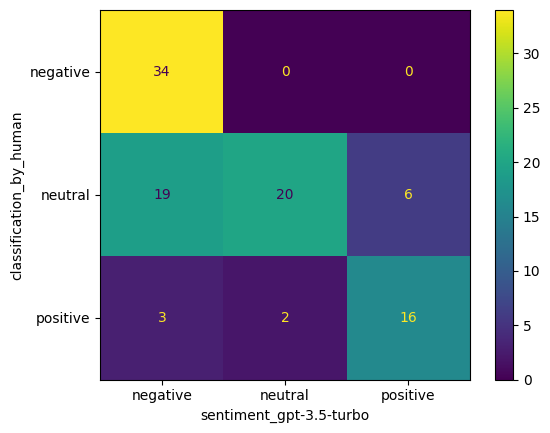



The confusion matrix for using sentiment_gpt-4-turbo-preview for the forum_posts_100_test:


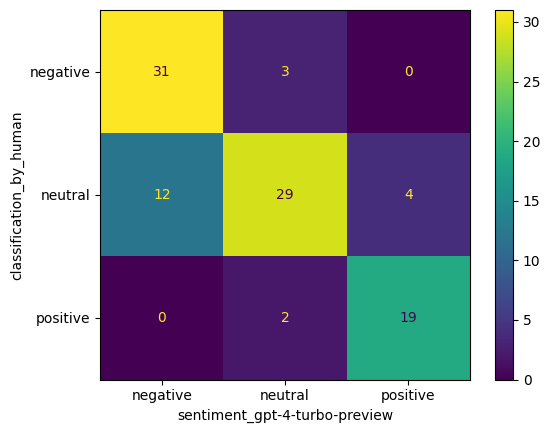

In [ ]:
# generating confusion matrices
y_true = df_forum_posts_100_test_gpt_classified["classification_by_human"]
column_names_model_predictions = [
    "sentiment_"+config["test_data_eval_model1"],
    "sentiment_"+config["test_data_eval_model2"]
    ]

for column_model_prediction in column_names_model_predictions:
  y_pred = df_forum_posts_100_test_gpt_classified[column_model_prediction]
  print(f"The confusion matrix for using {column_model_prediction} for the forum_posts_100_test:")
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
  plt.xlabel(column_model_prediction)
  plt.ylabel("classification_by_human")
  plt.show()
  print("\n")

## Additional Evaluations: Comparing the performance the better GPT model against the open-source models

In [ ]:
# As a small excursion we could do some metrics setting the better GPT model as "true" (e.g. "sentiment_gpt-4-turbo-preview" and the other models as prediction
# generating classification reports
y_true = df_forum_posts_100_test_gpt_classified["sentiment_"+config["train_data_eval_model"]]
column_names_model_predictions = [
    "sentiment_oliverguhr",
    "sentiment_bardsai",
    "sentiment_lxyuan",
    "sentiment_"+config["test_data_eval_model1"],
    "sentiment_"+config["test_data_eval_model2"]
    ]

for column_model_prediction in column_names_model_predictions:
  y_pred = df_forum_posts_100_test_gpt_classified[column_model_prediction]
  print(f"The classification report for using {column_model_prediction} and setting the GPT predictions of the better model set as 'true', for the forum_posts_100_test is: \n", classification_report(y_true, y_pred),  "\n")

The classification report for using sentiment_oliverguhr and setting the GPT predictions of the better model set as 'true', for the forum_posts_100_test is: 
               precision    recall  f1-score   support

    negative       0.50      0.51      0.51        43
     neutral       0.37      0.50      0.42        34
    positive       0.60      0.26      0.36        23

    accuracy                           0.45       100
   macro avg       0.49      0.42      0.43       100
weighted avg       0.48      0.45      0.45       100
 

The classification report for using sentiment_bardsai and setting the GPT predictions of the better model set as 'true', for the forum_posts_100_test is: 
               precision    recall  f1-score   support

    negative       0.64      0.16      0.26        43
     neutral       0.41      0.88      0.56        34
    positive       0.73      0.48      0.58        23

    accuracy                           0.48       100
   macro avg       0.59      0

The confusion matrix for using sentiment_oliverguhr for the forum_posts_100_test:


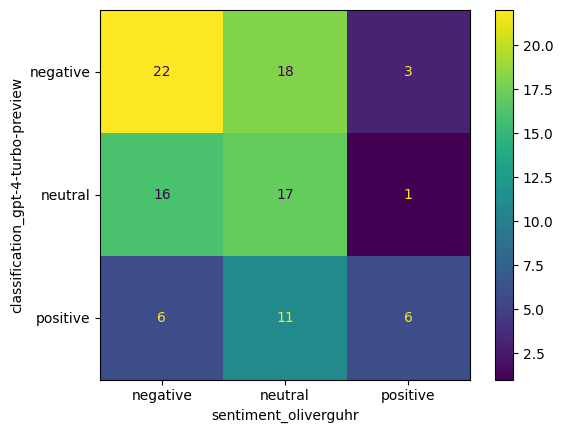



The confusion matrix for using sentiment_bardsai for the forum_posts_100_test:


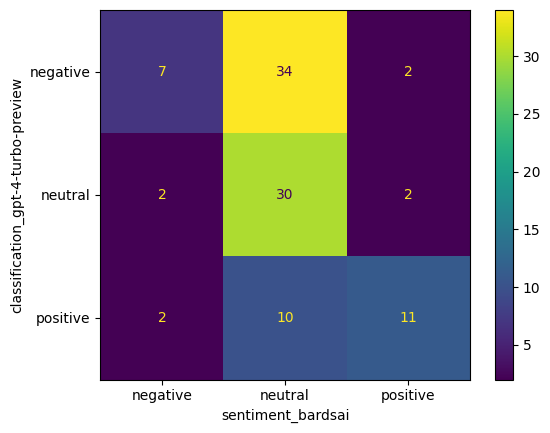



The confusion matrix for using sentiment_lxyuan for the forum_posts_100_test:


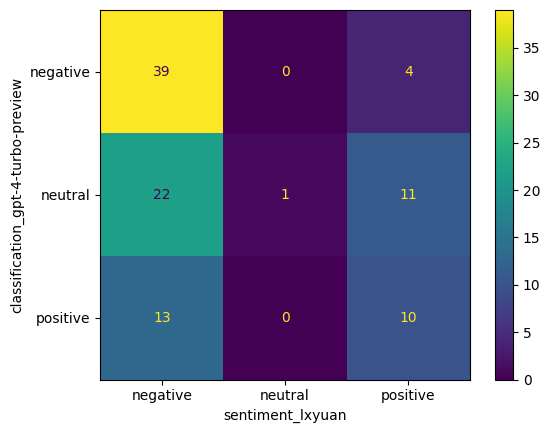



The confusion matrix for using sentiment_gpt-3.5-turbo for the forum_posts_100_test:


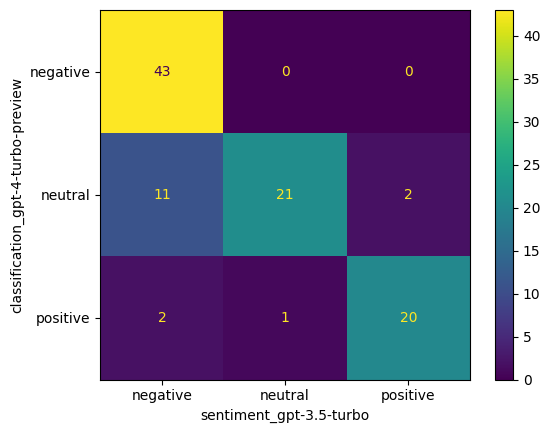



The confusion matrix for using sentiment_gpt-4-turbo-preview for the forum_posts_100_test:


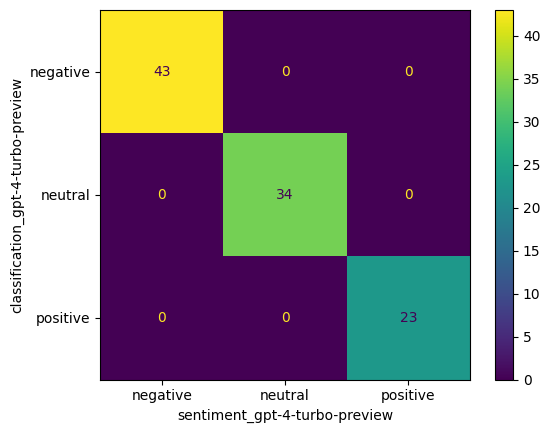

In [ ]:
# generating confusion matrices
y_true = df_forum_posts_100_test_gpt_classified["sentiment_"+config["train_data_eval_model"]]
column_names_model_predictions = [
    "sentiment_oliverguhr",
    "sentiment_bardsai",
    "sentiment_lxyuan",
    "sentiment_"+config["test_data_eval_model1"],
    "sentiment_"+config["test_data_eval_model2"]
    ]

for column_model_prediction in column_names_model_predictions:
  y_pred = df_forum_posts_100_test_gpt_classified[column_model_prediction]
  print(f"The confusion matrix for using {column_model_prediction} for the forum_posts_100_test:")
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
  plt.xlabel(column_model_prediction)
  plt.ylabel("classification_gpt-4-turbo-preview")
  plt.show()
  print("\n")